In [33]:
# Suggestion
# Make this grad engine for Tensors rather than scalars
# Use Numpy to implement your multi-dim primitive objects and its jacobian matrices
# Incorporate functions: add, sub, mul, div, relu, sigmoid, min, max, 
# Take care of cases where a node would split into 2 components when moving forward then during backprop 2 gradients would flow back to this node
# and in this case the gradients add up to be the total upstream gradient reaching this node
# Last one was impleented and taken care by multivariate chain rule of derivatives (the += collections of .grads attributes ;) )


In [34]:
# Sanity Checks:

# # Gradient of a vector is the same shape as the vector
# Check analytically simplified gradients with step approximation (f(x+h) - f(x)) / h 

In [35]:
# Sundar Sundar Computation Graphs

from graphviz import Digraph

def trace(root):
    # Builds a set of all nodes and edges in a graph
    nodes, edges = set(), set()
    def build(v):
        if v not in nodes:
            nodes.add(v)
            for child in v._prev:
                edges.add((child, v))
                build(child)
    build(root)
    return nodes, edges

def draw_dot(root):
    dot = Digraph(format='svg', graph_attr={'rankdir': 'LR'}) # LR = left to right
    
    # Improved styling
    dot.attr('node', shape='record', style='filled', fillcolor='lightblue', color='black', fontcolor='black', fontsize='12', fontname='Helvetica')
    dot.attr('edge', color='gray', arrowsize='0.8', fontsize='10')

    nodes, edges = trace(root)
    for n in nodes:
        uid = str(id(n))
        # Create a rectangular node with improved styling
        dot.node(name=uid, label="{ %s | data %.4f | grad %.4f }" % (n.label, n.data, n.grad))
        if n._op:
            # Create a diamond-shaped node for operations with distinct styling
            dot.node(name=uid + n._op, label=n._op, shape='diamond', style='filled', fillcolor='orange')
            # Connect this operation node to its result node
            dot.edge(uid + n._op, uid)

    for n1, n2 in edges:
        # Connect input nodes to the operation node
        dot.edge(str(id(n1)), str(id(n2)) + n2._op)

    return dot


In [109]:
# Our Quant = mini torch.tensor type object
# Quant Class definition
import math

    
         
class Quant:
    def __init__(self, data,_children =(),_op = '',label = f'' ):
        self.data =  data
        self._backward = lambda : None
        self.grad = 0.0
        self._prev = set(_children)
        self._op = _op
        self.label = label

    def __repr__(self) -> str:
        return f"Quant(data = {self.data},label:{self.label})"
    
    def __add__(self,other):
        other = other if isinstance(other,Quant) else Quant(other)
        out = Quant(data=self.data +other.data,_children = (self,other),_op = '+')
        
        def _backward():
            self.grad  += 1.0 * out.grad
            other.grad += 1.0* out.grad
            
        out._backward = _backward
        
        return out
    def __radd__(self,other):
        return (self + other)
    
    def __mul__(self,other):
        other = other if isinstance(other,Quant) else Quant(other)
        
        out = Quant(data = self.data*other.data,_children=(self,other),_op='*')
        
        def _backward():
            self.grad += other.data*out.grad
            other.grad += self.data * out.grad
        out._backward = _backward
        return out
    def __rmul__(self,other):
        return (self * other)
    
    def __truediv__(self,other):
        return (self * other**(-1))
    
    def __rtruediv__(self, other): # other / self
        return other * self**-1
        
    def __neg__(self): # -self
        return self * -1

    def __sub__(self, other): # self - other
        return self + (-other)
    
    def __rsub__(self,other):
        return (other+ (-self))

    def __pow__(self,other):
        ## Please only give other param to be float or int, why was this written this way? I will change it once the project is complete
        # for two nodes say x and y, if we compute d(x^y)/d(x), its simple y*x^(y-1)
        # but when it is d(x^y)/d(y) i.e when gradient flows back to the other node which will be x^y*log(y), we will have to 
        # incorporate logarithms with different bases, 
        # I will do it but please give me some time, karpathy didnt do it, but I will and I need time. 
        # When you actually change this code when other will be a quant object, make sure you give proper children parameters, rn its none
        # Because when gradients flow back, it only flows back to the unary connected node before it and other is just scalar so there is
        # no node for other in computation graph (FOR NOW)
        assert isinstance(other , (int,float))
        out = Quant(self.data ** other,_children=(self,),_op=f"**{other}")
        def _backward():
            self.grad += out.grad * other * (self.data**(other-1))
        out._backward = _backward
        return out
    
    def exp(self):
        out = Quant(data=math.exp(self.data),_children=(self,),_op='exp')

        def _backward():
            self.grad += out.grad*out.data
        out._backward = _backward
        return out
       
        
    def sigmoid(self,):
        sigmoid = 1.0/(1.0+math.exp(self.data)+1.0)
        out = Quant(data=sigmoid,_children=(self,),_op='sigmoid')
        
        def _backward():
            self.grad += out.grad * sigmoid * (1-sigmoid)
        
        out._backward = _backward
        
        return out
            
    def tanh(self,):
        tanh = (math.exp(2*self.data) - 1)/(math.exp(self.data *2 )+ 1)
        out = Quant(data=tanh,_children =  (self,),_op = 'tanh')
        
        def _backward():
            self.grad += (1-tanh**2)*out.grad 
        
        out._backward = _backward
        return out
    
    def min(self, other):
        other = other if isinstance(other, Quant) else Quant(other)
        out = Quant(data=(self.data if self.data < other.data else other.data), _children=(self, other), _op='min')
        
        def _backward():
            if self.data < other.data:
                self.grad += out.grad
            elif self.data > other.data:
                other.grad += out.grad
            else:  # if self.data == other.data
                self.grad += out.grad / 2
                other.grad += out.grad / 2
        
        out._backward = _backward
        return out

    def max(self, other):
        other = other if isinstance(other, Quant) else Quant(other)
        out = Quant(data=(self.data if self.data > other.data else other.data), _children=(self, other), _op='max')
        
        def _backward():
            if self.data > other.data:
                self.grad += out.grad
            elif self.data < other.data:
                other.grad += out.grad
            else:  # if self.data == other.data
                self.grad += out.grad / 2
                other.grad += out.grad / 2
        
        out._backward = _backward
        return out
    
    def backward(self,):
        # Routine for topo-sort of nodes
        topo= []
        visited = set()
        def topo_sort(vertex):
            if vertex not in visited:
                visited.add(vertex)
                for child in vertex._prev:
                    topo_sort(child)
                topo.append(vertex)
        topo_sort(self)
        
        # This is the 'processing' part
        self.grad = 1.0
        for node in reversed(topo):
            node._backward()
        #print("*****The Topo Sort for graph is ******")
        #print(topo)        
            

In [110]:
import random
random.seed(1337)
class Neuron:
    def __init__(self,n_in):
        self.W = [Quant(random.uniform(-1,1)) for _ in range(n_in)]
        self.b = (Quant(random.uniform(-1,1)))

    def __call__(self,x): # x is input
        activation = sum((wi*xi for wi,xi in zip(self.W,x)), start= self.b) 
        return activation.sigmoid().max(0.0)
    def parameters(self):
        return self.W + [self.b]
    
class layer:
    def __init__(self,n_in,n_out): # n_out is number of neurons
        self.neurons = [Neuron(n_in) for _ in range(n_out)]
        
    def __call__(self,x):
        logits = [n(x) for n in self.neurons]
        return logits[0] if len(logits)==1 else logits
    
    def parameters(self):
        return [param for nodes in self.neurons for param in nodes.parameters()]
    
                
class MLP:

    def __init__(self,n_in,n_outs): #n_outs is the list of number of output neurons in the ith layer
        layer_dims = [n_in] + n_outs
        self.layers = [layer(layer_dims[i],layer_dims[i+1]) for i in range(len(n_outs))]

    def __call__(self,x):
        for layer in self.layers:
            x = layer(x)
        return x
      
    def parameters(self):
        return [param for slice in self.layers for param in slice.parameters() ]
        # 
    def reset_grads(self):
        for params in self.parameters():
            params.grad = 0.0
            
    def update_params(self,lr = 0.0):
        for param in self.parameters():
            param.data += (-lr)*param.grad

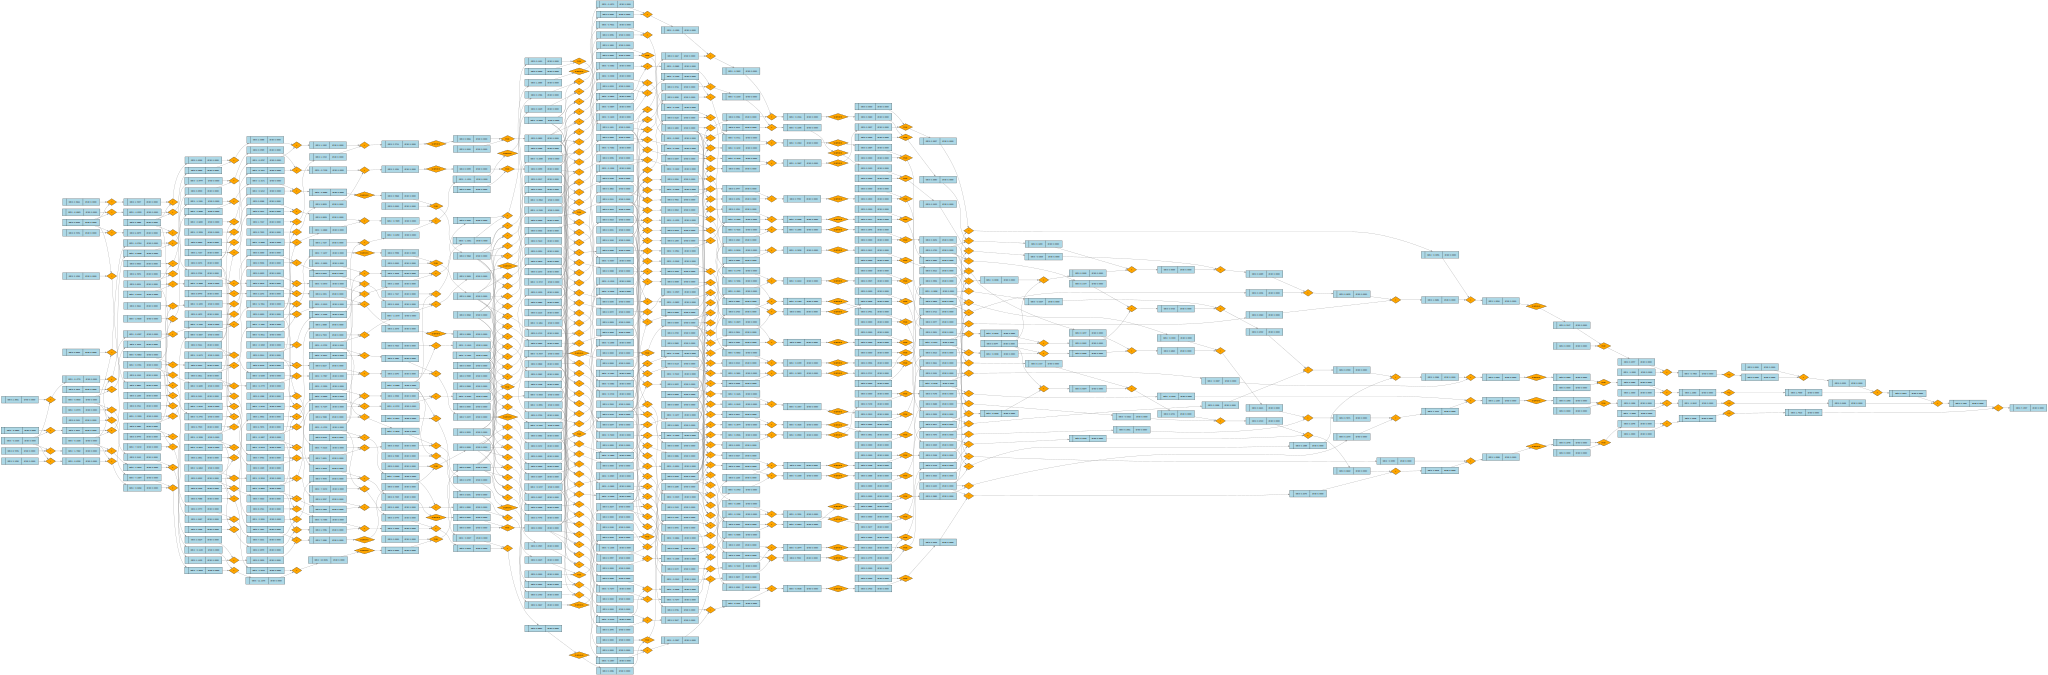

In [111]:
#random.seed(7070)

# Initializing a random dataset 
xs = [[random.uniform(-10,10) for _ in range(4)],
      [random.uniform(-10,10) for _ in range(4)],
      [random.uniform(-10,10) for _ in range(4)],
      [random.uniform(-10,10) for _ in range(4)]]
xs = [[round(xi,4) for xi in subxs] for subxs in xs]
ys = [1,-1,1,-1]
#pred = [MyMLP(xi) for xi in xs]
#loss = sum((pred_i - yi)**2 for (pred_i, yi) in zip(pred,ys) )

MyMLP = MLP(len(xs),[4,6,1])





In [112]:
#Training
from tqdm import tqdm
n_epochs = 1000
learning_rate = 0.001
for i in tqdm(range(n_epochs)):
    
    # Forward pass
    pred = [MyMLP(xi) for xi in xs]
    #print('Truth : ',ys)
    #print('Pred : ',[p.data for p in pred])
    loss = sum((pred_i - yi)**2 for (pred_i, yi) in zip(pred,ys) )
    if (not i %100):
        print( f'epoch: {i} loss:',loss.data)
    loss.grad = 1.0

    #Backward
    loss.backward()
    MyMLP.update_params(lr=learning_rate)

    # Preprocess for next epoch
    MyMLP.reset_grads()


print('Truth : ',ys)
print('Pred : ',[p.data for p in pred])
    

  1%|          | 12/1000 [00:00<00:19, 49.54it/s]

epoch: 0 loss: 4.190668749126381


 11%|█▏        | 114/1000 [00:01<00:12, 69.92it/s]

epoch: 100 loss: 4.20130796424351


 20%|██        | 203/1000 [00:03<00:13, 60.08it/s]

epoch: 200 loss: 4.212700700240424


 32%|███▏      | 318/1000 [00:05<00:09, 71.93it/s]

epoch: 300 loss: 4.224715923791437


 40%|████      | 404/1000 [00:06<00:09, 61.39it/s]

epoch: 400 loss: 4.237290339829677


 51%|█████     | 506/1000 [00:08<00:06, 71.98it/s]

epoch: 500 loss: 4.250481347993301


 60%|██████    | 600/1000 [00:10<00:07, 56.38it/s]

epoch: 600 loss: 4.264434659100383


 69%|██████▉   | 692/1000 [00:11<00:05, 54.95it/s]

epoch: 700 loss: 4.279327248805173


 78%|███████▊  | 784/1000 [00:13<00:04, 53.58it/s]

epoch: 800 loss: 4.295330954463958


 91%|█████████ | 910/1000 [00:15<00:01, 58.27it/s]

epoch: 900 loss: 4.312598688731803


100%|██████████| 1000/1000 [00:17<00:00, 58.80it/s]

Truth :  [1, -1, 1, -1]
Pred :  [0.2777882187984633, 0.28029994903779615, 0.2704282339032168, 0.2798572916238088]
